In [7]:
# Importing all the modules we need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Checking to see if a gpu is available for training
device_type = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device_type)

# Setting a transform variable for data transformation
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Loading training and test Cifar-10 datasets
train_set=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_set=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(test_set,batch_size=32,shuffle=False,num_workers=2)

# Data classes to be trained and tested
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print (classes)

GPU state: cpu
Files already downloaded and verified
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [8]:
# CNN model architecture
model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): BatchNorm2d(256, eps=1e-

In [12]:
# Check training device and send model to device for training
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Setting network parameters 
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# Using model summary feature
from torchsummary import summary

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Viewing network parameters
summary(model,(3,32,32))
count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

5852234

In [17]:
# Setting model training Loss and Accuracy variables 
train_losses=[]
train_accu=[]

# Model training function
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0


  # Determining training loss from model predictions
  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    # Replaces pow(2.0) with abs() for L1 regularization
    
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  # Defining training loss
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total

  # Printing model testing progress during training
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

# Setting model validation(test) Loss and Accuracy variables 
eval_losses=[]
eval_accu=[]

# Model validation(test) function
def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  # Printing model testing progress during training
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))

# Training epochs
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|███████████████████████████████████████| 1563/1563 [25:24<00:00,  1.03it/s]


Train Loss: 1.641 | Accuracy: 81.786


100%|█████████████████████████████████████████| 313/313 [01:23<00:00,  3.74it/s]


Test Loss: 0.594 | Accuracy: 79.500

Epoch : 2


100%|███████████████████████████████████████| 1563/1563 [20:12<00:00,  1.29it/s]


Train Loss: 1.460 | Accuracy: 86.518


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.82it/s]


Test Loss: 0.598 | Accuracy: 79.540

Epoch : 3


100%|███████████████████████████████████████| 1563/1563 [20:12<00:00,  1.29it/s]


Train Loss: 1.313 | Accuracy: 90.410


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.84it/s]


Test Loss: 0.540 | Accuracy: 82.450

Epoch : 4


100%|███████████████████████████████████████| 1563/1563 [20:08<00:00,  1.29it/s]


Train Loss: 1.185 | Accuracy: 93.572


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.83it/s]


Test Loss: 0.580 | Accuracy: 81.620

Epoch : 5


100%|███████████████████████████████████████| 1563/1563 [20:09<00:00,  1.29it/s]


Train Loss: 1.092 | Accuracy: 95.570


100%|█████████████████████████████████████████| 313/313 [01:20<00:00,  3.87it/s]


Test Loss: 0.597 | Accuracy: 82.070

Epoch : 6


100%|███████████████████████████████████████| 1563/1563 [20:22<00:00,  1.28it/s]


Train Loss: 1.012 | Accuracy: 97.058


100%|█████████████████████████████████████████| 313/313 [01:22<00:00,  3.80it/s]


Test Loss: 0.650 | Accuracy: 81.550

Epoch : 7


100%|███████████████████████████████████████| 1563/1563 [20:17<00:00,  1.28it/s]


Train Loss: 0.941 | Accuracy: 98.264


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.83it/s]


Test Loss: 0.645 | Accuracy: 82.070

Epoch : 8


100%|███████████████████████████████████████| 1563/1563 [20:24<00:00,  1.28it/s]


Train Loss: 0.875 | Accuracy: 99.176


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.82it/s]


Test Loss: 0.632 | Accuracy: 83.260

Epoch : 9


100%|███████████████████████████████████████| 1563/1563 [20:09<00:00,  1.29it/s]


Train Loss: 0.811 | Accuracy: 99.874


100%|█████████████████████████████████████████| 313/313 [01:22<00:00,  3.82it/s]


Test Loss: 0.579 | Accuracy: 84.170

Epoch : 10


100%|███████████████████████████████████████| 1563/1563 [20:09<00:00,  1.29it/s]


Train Loss: 0.759 | Accuracy: 99.984


100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.83it/s]

Test Loss: 0.549 | Accuracy: 85.040


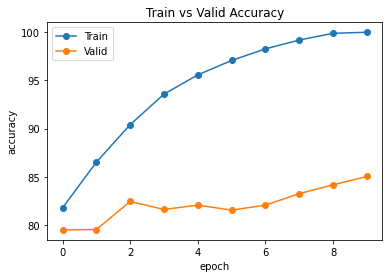

In [18]:
# Accuracy Plot

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

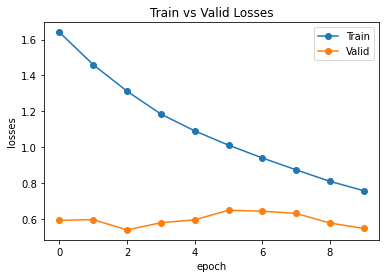

In [19]:
# Loss plot
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

100%|█████████████████████████████████████████| 313/313 [01:21<00:00,  3.86it/s]


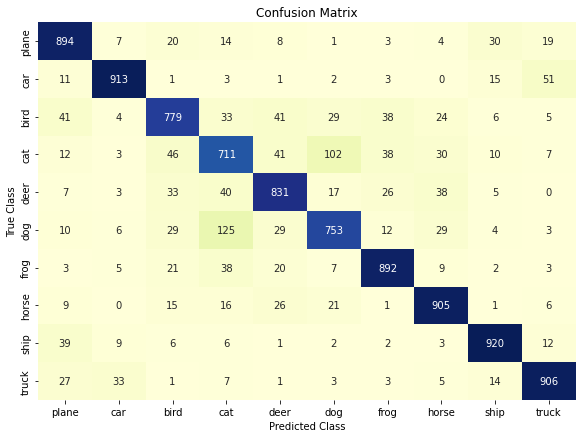

In [20]:
# Gathering data for model analysis by a confusion matrix
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

# Labelling confusion matrix axis
cf_matrix = confusion_matrix(y_true, y_pred)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create pandas dataframe and plot figure
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))

# Create heatmap of the confusion matrix and view in matplotlib
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()